In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

## Binary classification

In [9]:
N = 500
D = 2
beta_true = np.asarray([1.0, -1.0]).reshape((2, 1))
dataX = np.random.normal(0, 1, N * D).reshape(N, D)
prob = 1.0 / (1.0 + np.exp(-np.dot(dataX, beta_true)))
dataY = np.random.binomial(1, prob) * 1.0
print(dataX.shape)
print(dataY.shape)

(500, 2)
(500, 1)


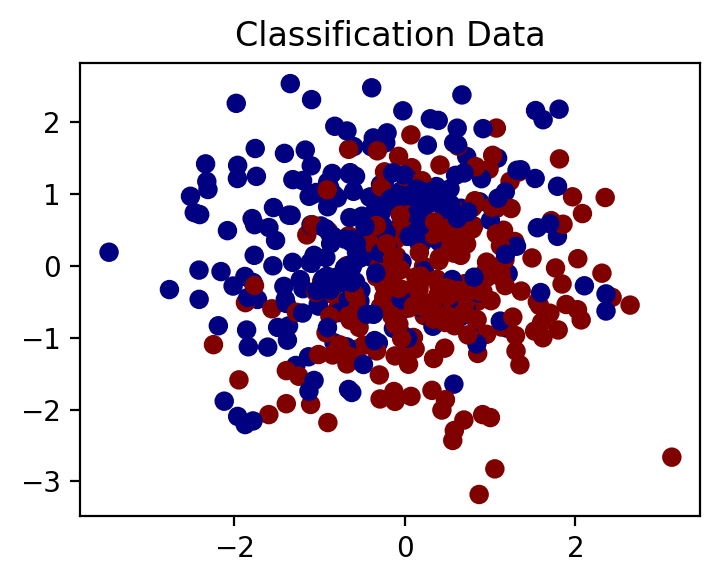

In [10]:
fig = plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(dataX[:, 0], dataX[:, 1], c=dataY[:, 0], cmap='jet')
plt.title('Classification Data')
plt.show()

## Tensorflow

Placeholding tensors are for variables. Their dimensions must be declared.

In [11]:
X = tf.placeholder('float', [None, D]) 
Y = tf.placeholder('float', [None, 1])

Variable is for parameters. The initial values are randomly drawn from Normal distribution.

In [12]:
#beta = tf.Variable(tf.random_normal([D, 1], stddev=1.0))
beta = tf.get_variable('beta', shape=[D, 1], initializer=tf.zeros_initializer())

Perceptron output with sigmoid activation is also predicted probability.

In [13]:
pred = 1.0 / (1.0 + tf.exp(-tf.matmul(X, beta)))

## Loss function

The loss (cost) function *L* evaluates model performance by comparing *y_pred* against *y_true*. Since *y_pred* is a function of model parameters (weights and biases), we can imagine a loss landscape of *L(y_pred, y_true)* with respect to model parameters. 

In [14]:
loss = -1.0 * (tf.reduce_sum(Y * tf.log(pred) + (1.0 - Y) * tf.log(1 - pred)))  
# binary cross entropy loss or negative log likelihood

In [15]:
value = tf.placeholder('float', [D, 1])
assignment = beta.assign(value)

loss_landscape = np.zeros((40, 40))  # 40 by 40 grid

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(40):
        position = np.zeros((2, 1))
        position[0, 0] = i * 0.1 - 2
        for j in range(40):
            position[1, 0] = j * 0.1 - 2
            sess.run(assignment, feed_dict={value: position})  # move around parameter space
            l = sess.run(loss, feed_dict={X: dataX, Y: dataY})  # calculate loss value
            loss_landscape[i, j] = l

In [16]:
xx, yy = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [18]:
print(xx.shape)

(40, 40)


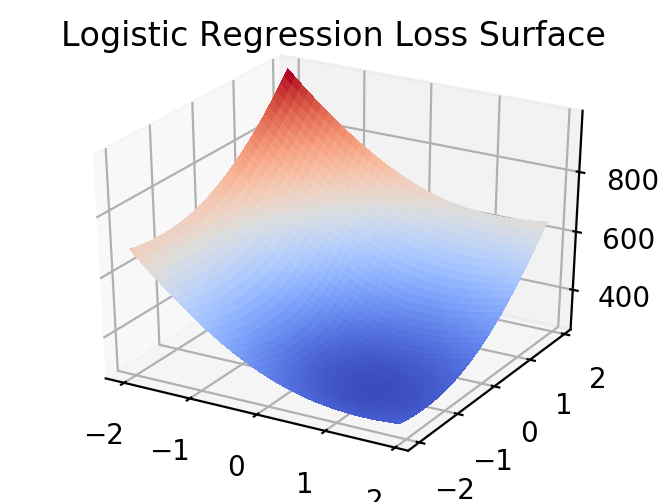

In [19]:
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(yy, xx, loss_landscape, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title('Logistic Regression Loss Surface')
plt.show()

## Gradient descent

Hence training a neural network is an optimization problem: finding the optimal parameters to minimize the loss function. The gradient descent algorithm attempts to find the minimum in the loss landscape by following the gradient (downward slope).

In [20]:
grad = tf.gradients(loss, beta)

In [21]:
print(grad)

[<tf.Tensor 'gradients/MatMul_grad/MatMul_1:0' shape=(2, 1) dtype=float32>]


**Exercise 3**

In [22]:
train_op = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
#GradientDescentOptimizer(step size)

In [23]:
step_size = 0.002
n_step = 100
beta_path = np.zeros((n_step, 2))  # gradient descent path

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(n_step):
        sess.run(train_op, feed_dict={X: dataX, Y: dataY})
        beta_path[i, :] = beta.eval().reshape(D)

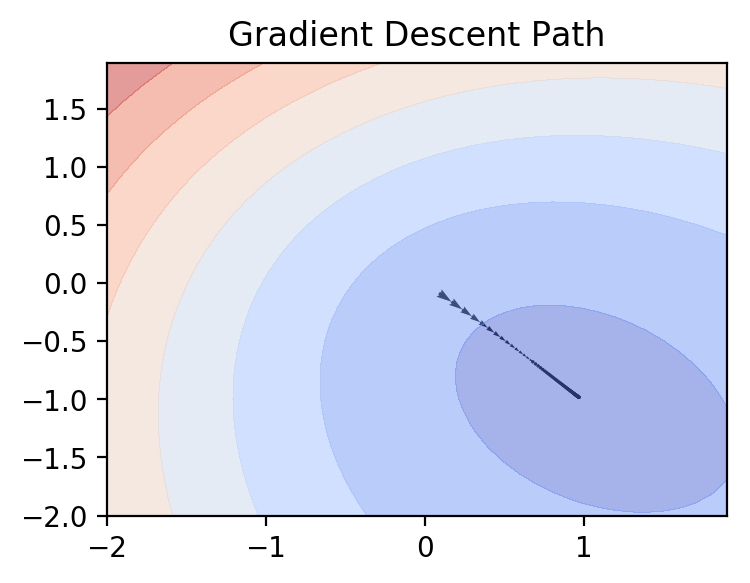

In [24]:
fig = plt.figure(figsize=(4, 3), dpi=200)
x = beta_path[:, 0]
y = beta_path[:, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1.0)
plt.contourf(yy, xx, loss_landscape, alpha=0.5, cmap='coolwarm')
plt.title('Gradient Descent Path')
plt.show()

In [25]:
W1 = tf.Variable(tf.random_normal([D, 100], stddev=1.0))
b1 = tf.Variable(tf.random_normal([1, 100], stddev=1.0))
h1 = tf.nn.sigmoid(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([100, 10], stddev=1.0))
b2 = tf.Variable(tf.random_normal([1, 10], stddev=1.0))
h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2)

W3 = tf.Variable(tf.random_normal([10, 1], stddev=1.0))
b3 = tf.Variable(tf.random_normal([1, 1], stddev=1.0))

pred = tf.nn.sigmoid(tf.matmul(h2, W3) + b3)

In [26]:
loss = -1.0 * (tf.reduce_sum(Y * tf.log(pred) + (1.0 - Y) * tf.log(1 - pred)))

In [27]:
value = tf.placeholder('float', [2, 100])
assignment = W1.assign(value)

loss_landscape = np.zeros((40, 40))
projection = np.random.normal(0, 1, 400).reshape((200, 2))  # random projection matrix

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(40):
        position = np.zeros((2, 1))
        position[0, 0] = i * 0.1 - 2
        for j in range(40):
            position[1, 0] = j * 0.1 - 2
            sess.run(assignment, feed_dict={value: np.dot(projection, position).reshape((2, 100))}) 
            l = sess.run(loss, feed_dict={X: dataX, Y: dataY})
            loss_landscape[i, j] = l

In [28]:
xx, yy = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))

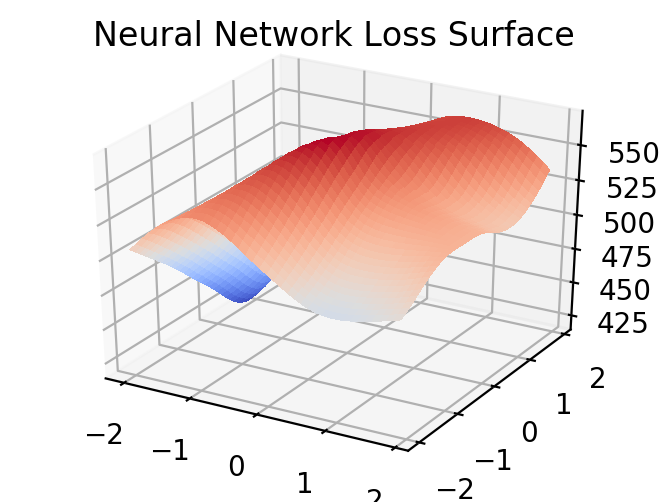

In [29]:
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, loss_landscape, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title('Neural Network Loss Surface')
plt.show()

## Back-propagation

The back-propagation algorithm calculates the gradient with chain rule recursively. http://colah.github.io/posts/2015-08-Backprop/

![Backprop](https://raw.githubusercontent.com/UCIDataScienceInitiative/LearningWithPython/master/figures/graph.png)

## Local minima and stochastic gradient descent

Gradient descent is a first-order "local" algorithm and can be trapped in local minima. Stochastic gradient descent only uses a batch of the data at a time and can be combined with "tricks" such as momentum and learning rate decay. Training neural networks involve tuning various hyperparameters:

* learning rate or step size, batch size
* momentum, learning rate schedule...

https://blog.paperspace.com/intro-to-optimization-in-deep-learning-gradient-descent/

![Loss](https://raw.githubusercontent.com/UCIDataScienceInitiative/LearningWithPython/master/figures/landscape.png)